In [1]:
import re
import numpy
import math
import sys
import collections
import exceptions
import pickle
from collections import defaultdict
import pandas as pd
import numpy as np

def flag2value(tcpflag):
    summation = 0;
    flags = tcpflag.split(", ")
    flag=['PSH','SYN','ACK','URG','FIN','RST']
    for i in flags:
        if i in flag:
            summation+=2**(5-flag.index(i))
    return summation

def flag_frequencies(filename):
    ip_pair_flags = {}
    #subprocess.call('sudo tcpdump -n -r '+filename+' -i eth0 "tcp"> '+filename+'.txt', shell=True)
    with open(filename) as f:
        flags = [0] * 64
        packet_count = 0

        for line in f.readlines():

            ip_pair = re.findall(r'[0-9]+(?:\.[0-9]+){3}',line)
            packet_count += 1

            if len(ip_pair)==2:

                ip_pair.sort()

                if re.findall(r'(?<=\[).+?(?=\])',line):
                    tcp_flag = flag2value( re.findall(r'(?<=\[).+?(?=\])',line)[0] )
                    #ip_pair_flags[str(ip_pair)]
                    if str(ip_pair) in ip_pair_flags:
                        #print tcp_flag
                        
                        ip_pair_flags[str(ip_pair)][tcp_flag-1] += 1
                        flags[tcp_flag-1] += 1
                    else:
                        # 6 flag combos 
                        ip_pair_flags [str(ip_pair)] = [0]*64
                        ip_pair_flags [str(ip_pair)] [tcp_flag-1] += 1
                        flags[tcp_flag-1] += 1
    
    return ip_pair_flags


In [62]:
protocols = ["http", "https", "ftp", "smtp", "dns", "bgp", "telnet", "pop", "imap"]

for proto in protocols:
    flag_freq = pd.DataFrame()
    pair_flags = flag_frequencies("normal-"+proto+".txt")
    flag_freq = pd.DataFrame.from_dict(pair_flags, orient='index')
    flag_freq["sum"] = flag_freq.sum(axis=1)
    flag_freq = flag_freq[flag_freq["sum"] > 50]
    flag_freq = flag_freq.loc[:].div(flag_freq["sum"], axis=0)    
    flag_freq = flag_freq.drop('sum', axis=1)
    flag_freq["protocol"] = proto
    flag_freq.to_csv("normal-"+proto+"AllFlagFreq.csv")
    flag_freq = flag_freq.replace(0, np.nan)
    flag_freq = flag_freq.dropna(how='all', axis=1)
    flag_freq.to_csv("normal-"+proto+"9FlagFreq.csv", na_rep='0')


In [58]:
protocols = ["http", "https", "ftp", "smtp", "dns", "bgp", "telnet", "pop", "imap"]
total_freq = pd.DataFrame()

for proto in protocols:
    freq = pd.read_csv("normal-"+proto+"9FlagFreq.csv")
    total_freq = total_freq.append(freq)
    
total_freq = total_freq.drop('Unnamed: 0', axis=1)
total_freq.head()

,0,15,23,39,41,63,7,8,9,protocol
0,0.0,0.000000,0.058824,0.392157,0.000000,0.000000,0.392157,0.078431,0.078431,http
1,0.0,0.000000,0.000000,0.017820,0.000000,0.659329,0.322851,0.000000,0.000000,http
2,0.0,0.000000,0.018018,0.000000,0.000000,0.954955,0.018018,0.000000,0.009009,http
3,0.0,0.027027,0.027027,0.099099,0.009009,0.072072,0.729730,0.000000,0.036036,http
4,0.0,0.028571,0.026786,0.100000,0.008036,0.147321,0.639286,0.000000,0.050000,http


In [118]:
from sklearn.cluster import KMeans
from sklearn.cross_validation import train_test_split

total_freq = total_freq.replace(np.nan, 0)
X = total_freq.drop('protocol', axis=1)
y = total_freq['protocol']
column_list = list(X.columns.values)
data = pd.DataFrame(X, columns=column_list)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.75)

In [119]:
from sklearn.cluster import KMeans
import numpy as np
from dstools import data_tools
from IPython.display import display, HTML
from scipy.spatial.distance import cosine
from scipy.spatial.distance import pdist, squareform

k_clusters = 9
model = KMeans(k_clusters)
model.fit(X)
clusters = model.predict(X)

# Do some messy stuff to print a nice table of clusters
cluster_listing = {}
for cluster in range(k_clusters):
    cluster_listing['Cluster ' + str(cluster)] = [''] * 109
    where_in_cluster = np.where(clusters == cluster)[0]
    cluster_listing['Cluster ' + str(cluster)][0:len(where_in_cluster)] = data.index[where_in_cluster]

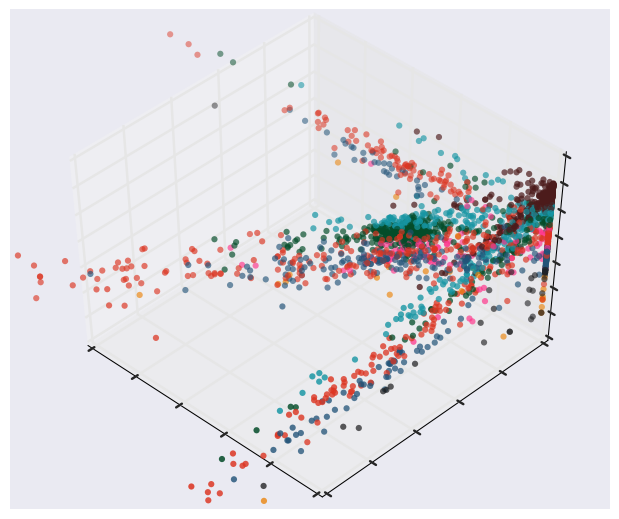

In [120]:
import seaborn
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import markers
from pandas.tools.plotting import scatter_matrix

fig = plt.figure(1, figsize=(6, 5))
plt.clf()
ax = Axes3D(fig, elev=48, azim=134)

#Plot all data points on scatter chart
ax.scatter(X.iloc[:, 1], X.iloc[:, 2], X.iloc[:, 6], color=data_tools.colorizer(clusters), linewidth=0, s=20)
ax.set_xlim(0, 0.1)
ax.set_ylim(0, 0.1)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.w_xaxis.limit_range_for_scale
plt.show()


In [121]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

from sklearn import decomposition
from sklearn import datasets

pca = decomposition.PCA(n_components=3)
pca.fit(X)
X = pca.transform(X)
X = pd.DataFrame(X)

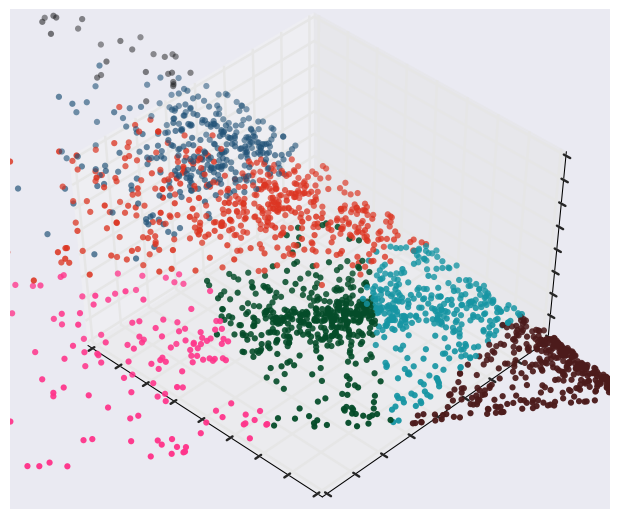

In [124]:
fig = plt.figure(1, figsize=(6, 5))
plt.clf()
ax = Axes3D(fig, elev=48, azim=134)

#Plot all data points on scatter chart
ax.scatter(X.iloc[:, 0], X.iloc[:, 1], X.iloc[:, 2], color=data_tools.colorizer(clusters), linewidth=0, s=20)
ax.set_xlim(-0.2, 0.2)
ax.set_ylim(-0.2, 0.2)
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
plt.show()